In [1]:
import fitness.data_generating_process as dgp
from fitness.soga_fitness_trueskills import *
from utils import *

import numpy as np
from scipy.stats import multivariate_normal

import torch
torch.set_default_dtype(torch.float64)

%matplotlib inline

# Burglary

In [2]:
model_name = 'burglary' 

### Data from the original data generating process

In [3]:
"""

def generate_burglary_dataset(data_size):
    data = []
    for _ in range(data_size):
        burglary = np.random.binomial(1, 0.001)  # 0.001
        earthquake = np.random.binomial(1, 0.002) # 0.002
        if burglary:
            if earthquake:
                alarm = np.random.binomial(1, 0.95)
            else:
                alarm = np.random.binomial(1, 0.94)
        else:
            if earthquake:
                alarm = np.random.binomial(1, 0.29)
            else:
                alarm = np.random.binomial(1, 0.001) # 0.001
        if alarm:
            johncalls = np.random.binomial(1, 0.9)
        else:
            johncalls = np.random.binomial(1, 0.05)
        data.append([burglary, earthquake, alarm, johncalls])
    return data
    
"""

'\n\ndef generate_burglary_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        burglary = np.random.binomial(1, 0.001)  # 0.001\n        earthquake = np.random.binomial(1, 0.002) # 0.002\n        if burglary:\n            if earthquake:\n                alarm = np.random.binomial(1, 0.95)\n            else:\n                alarm = np.random.binomial(1, 0.94)\n        else:\n            if earthquake:\n                alarm = np.random.binomial(1, 0.29)\n            else:\n                alarm = np.random.binomial(1, 0.001) # 0.001\n        if alarm:\n            johncalls = np.random.binomial(1, 0.9)\n        else:\n            johncalls = np.random.binomial(1, 0.05)\n        data.append([burglary, earthquake, alarm, johncalls])\n    return data\n    \n'

In [4]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)
print(data_var_list)

['burglary', 'earthquake', 'alarm', 'johncalls']


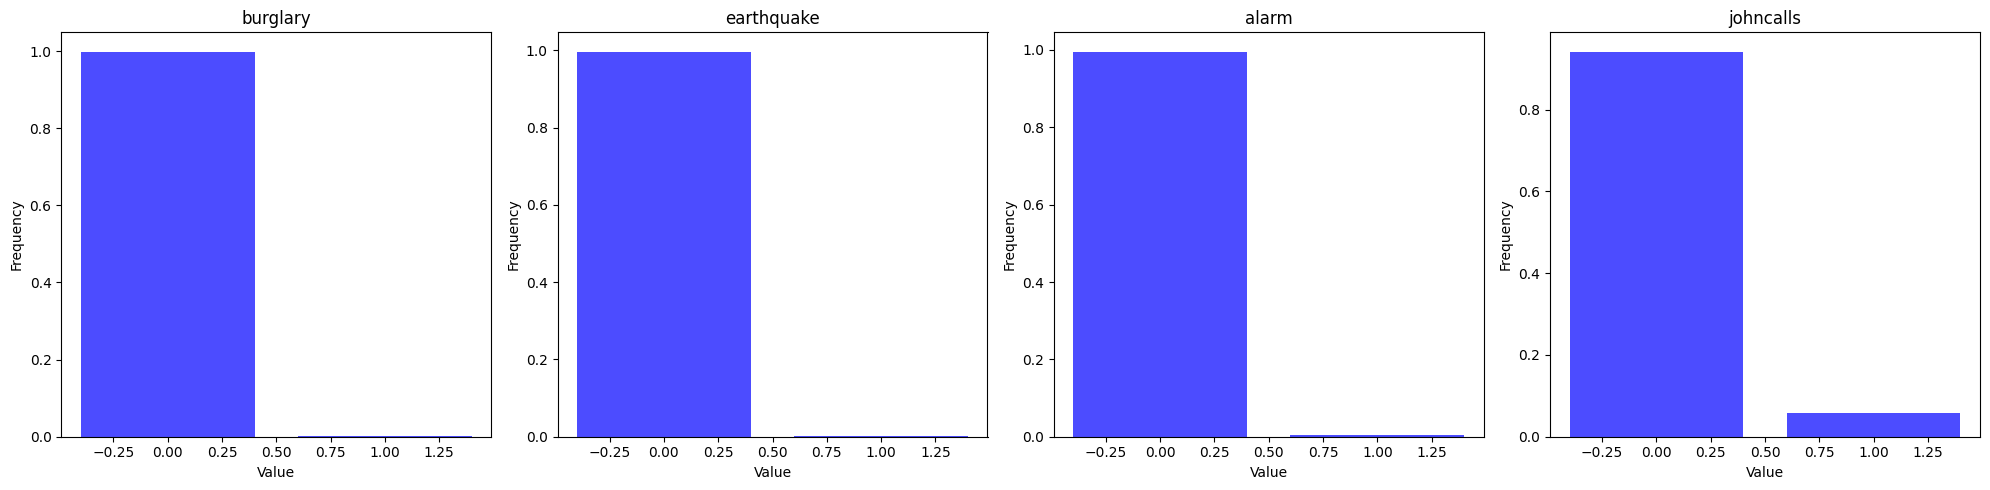

In [5]:
create_histogram(data, data_var_list)

In [6]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-0.2596)


### No sketching

In [12]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             1000
POPULATION_SIZE:         250



In [13]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [14]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-0.2596)
Found Program 
 burglary = 4  * burglary  - 5  * earthquake; 
  earthquake = gm([0, 1, 0], [9, 0, 0]) + 6 * 8; 
  alarm = burglary; 
  johncalls = gm([0, 1, 0], [6, 0, 0]); 
  earthquake = 1  * burglary + burglary;
 
 


In [15]:
samples = sample_gmm(output_dist, 10000)

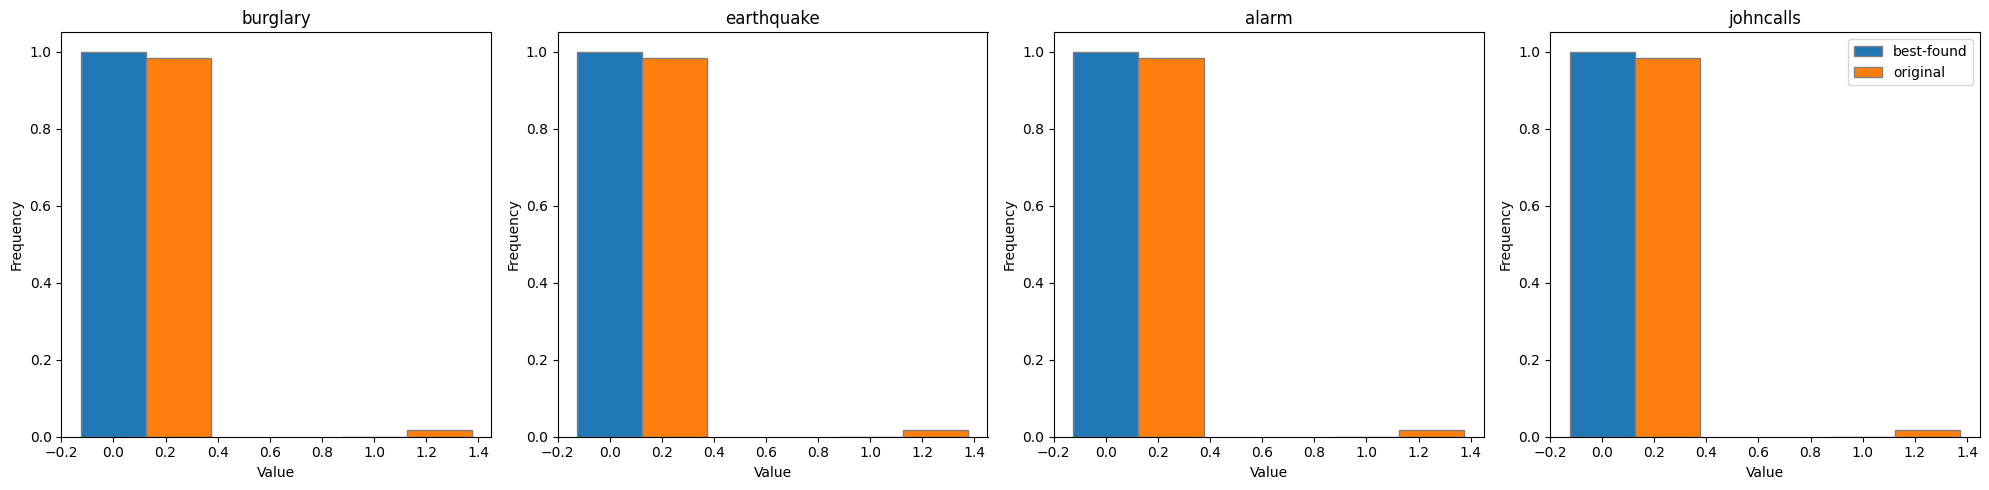

In [16]:
# original histogram
create_histograms([samples, data], ['best-found', 'original'], data_var_list)

### Sketching - no benefit

In [21]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             500
POPULATION_SIZE:         200



In [22]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [23]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-0.2596)
Found Program 
 burglary = gm([2, 1, 0], [19, 0, 0]) + 30 * 0; 
  earthquake = 10  * johncalls + 11  * alarm; 
  if burglary == 1 { 
    if earthquake == 1 { 
      alarm = 23; 
    } else { 
      alarm = 8 + 3; 
    } end if; 
  } else { 
    if earthquake == 1 { 
      alarm = 7  * gm([5, 1, 0], [25, 0, 0]) + 4  * gm([30, 1, 0], [0, 0, 0]); 
    } else { 
      alarm = 10  * johncalls + 11  * alarm; 
    } end if; 
  } end if; 
  if alarm == 1 { 
    johncalls = 21  * johncalls  - johncalls; 
  } else { 
    johncalls = burglary + 25  * earthquake; 
  } end if;
 
 


In [24]:
samples = sample_gmm(output_dist, 5000)

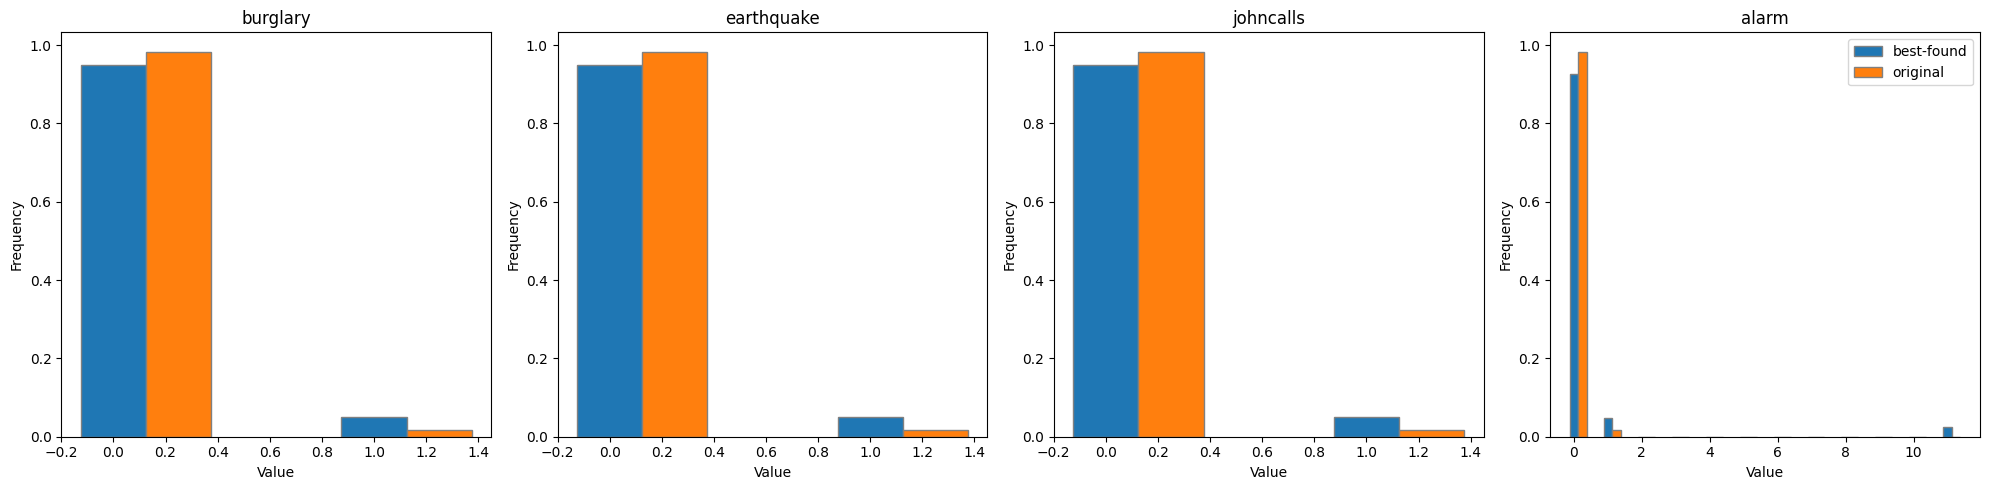

In [25]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# CSI

In [26]:
model_name = 'csi'

### Data from the original data generating process

In [27]:
"""
def generate_csi_dataset(data_size):
    data = []
    for _ in range(data_size):
        u = np.random.binomial(1, 0.3)
        v = np.random.binomial(1, 0.9)
        w = np.random.binomial(1, 0.1)
        if u:
            if w:
                x = np.random.binomial(1, 0.8)
            else:
                x = np.random.binomial(1, 0.2)
        else:
            if v:
                x = np.random.binomial(1, 0.8)
            else:
                x = np.random.binomial(1, 0.2)
        data.append([u, v, w, x])
    return data
"""

'\ndef generate_csi_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        u = np.random.binomial(1, 0.3)\n        v = np.random.binomial(1, 0.9)\n        w = np.random.binomial(1, 0.1)\n        if u:\n            if w:\n                x = np.random.binomial(1, 0.8)\n            else:\n                x = np.random.binomial(1, 0.2)\n        else:\n            if v:\n                x = np.random.binomial(1, 0.8)\n            else:\n                x = np.random.binomial(1, 0.2)\n        data.append([u, v, w, x])\n    return data\n'

In [28]:
data = dgp.generate_dataset('csi', 5000)
data_var_list, dependencies, weights = dgp.get_vars('csi')

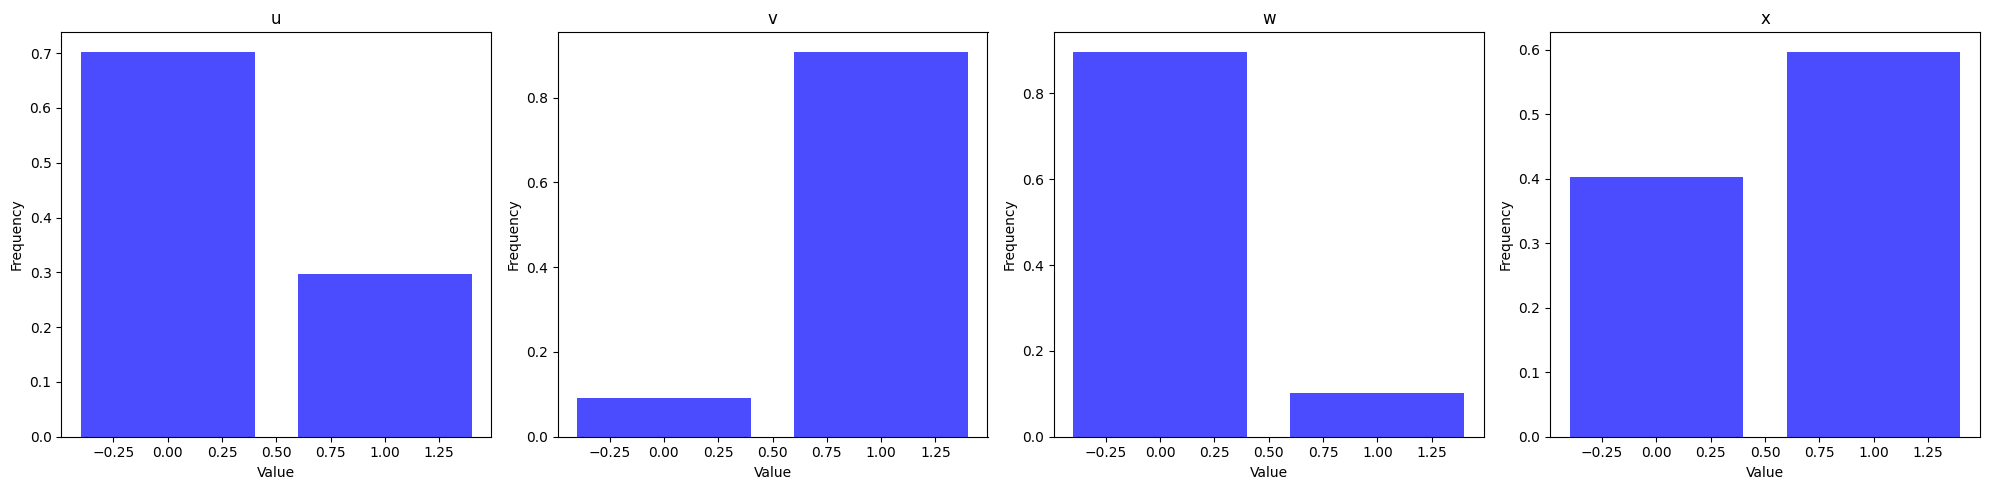

In [29]:
create_histogram(data, data_var_list)

In [30]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-1.7506)


### No sketching

In [31]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             1000
POPULATION_SIZE:         250



In [32]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [33]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-1.7506)
Found Program 
 u = gm([11, 1, 0], [22, 0, 0]) + gm([1, 1, 0], [28, 0, 0]); 
  v = v + gm([25, 1, 0], [10, 0, 0]); 
  w = gm([14, 1, 0], [30, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([8, 1, 0], [21, 0, 0]); 
    } else { 
      x = 1  * w + gm([2, 1, 0], [11, 0, 0]); 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([3, 1, 0], [1, 0, 0]); 
    } else { 
      x = x + v; 
    }end if; 
  }end if;
 
 


In [34]:
samples = sample_gmm(output_dist, 5000)

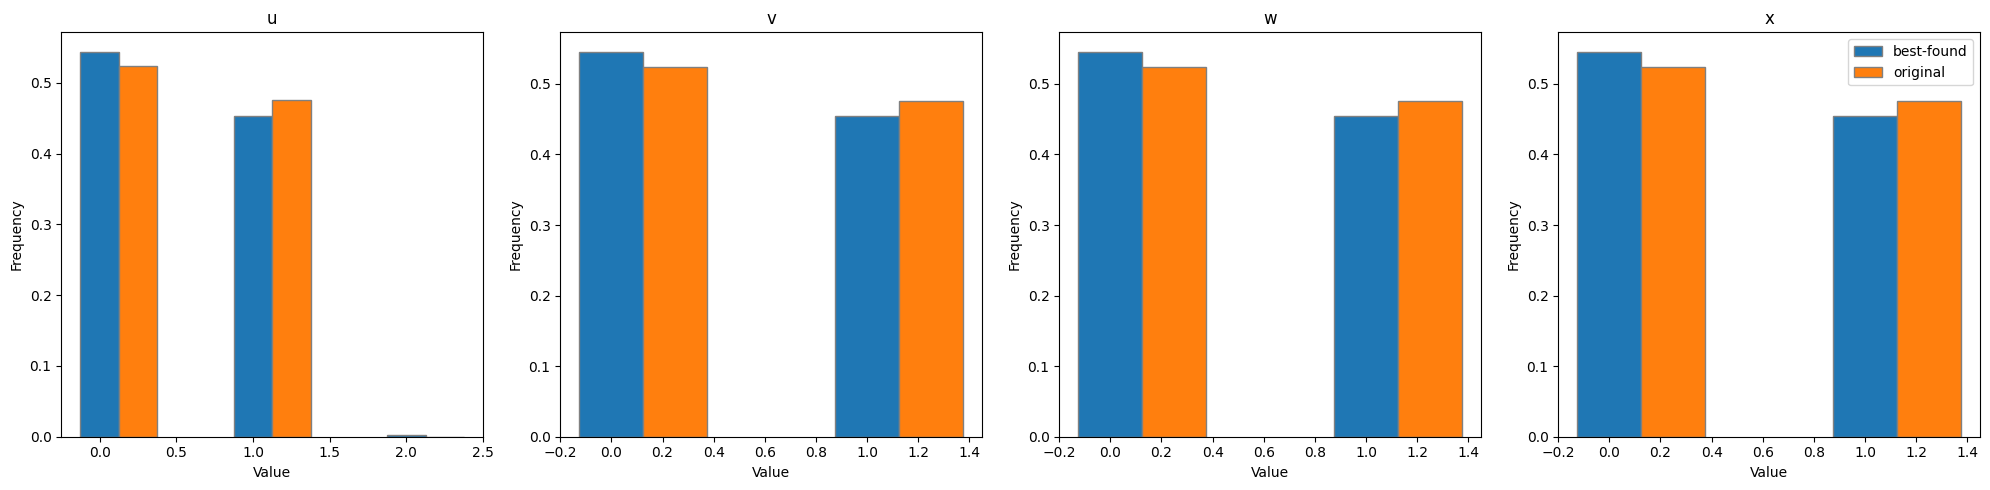

In [35]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [36]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             1000
POPULATION_SIZE:         250



In [37]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-1.8963)


In [38]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-1.8963)
Fitness of baseline:  tensor(-1.7506)
Found Program 
 u = 0  * gm([7, 1, 0], [29, 0, 0]) + gm([17, 1, 0], [29, 0, 0]); 
  v = gm([24, 1, 0], [5, 0, 0]); 
  w = gm([1, 1, 0], [24, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([12, 1, 0], [7, 0, 0]); 
    } else { 
      x = gm([15, 1, 0], [13, 0, 0])  - x; 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([27, 1, 0], [6, 0, 0]); 
    } else { 
      x = gm([13, 1, 0], [22, 0, 0]); 
    }end if; 
  }end if;
 
 


In [39]:
samples = sample_gmm(output_dist, 10000)

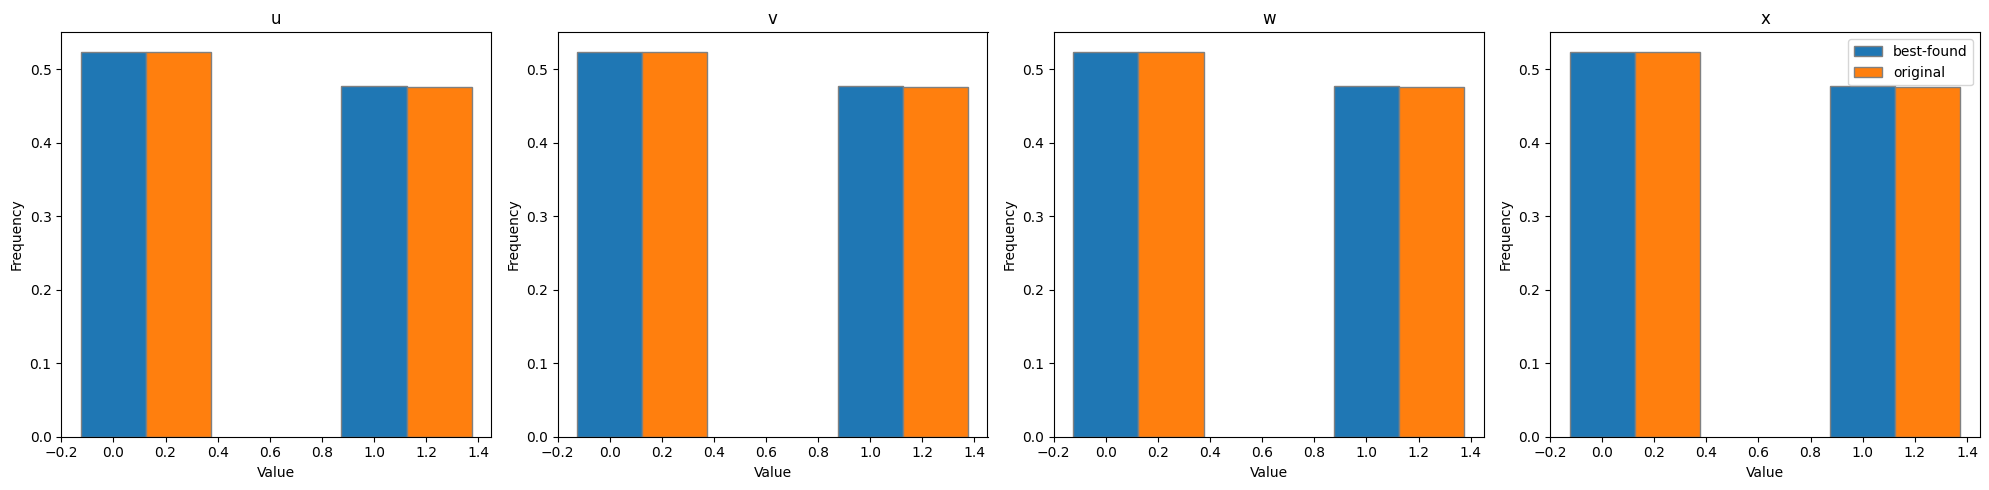

In [40]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Healthiness

In [41]:
model_name = 'healthiness'

### Data from the original data generating process

In [42]:
"""
def generate_healthiness_dataset(data_size):
    data = []
    for _ in range(data_size):
        healthconscius = np.random.binomial(1, 0.5)
        littlefreetime = np.random.binomial(1, 0.5)
        if healthconscius:
            if littlefreetime:
                exercise = np.random.binomial(1, 0.5)
            else:
                exercise = np.random.binomial(1, 0.9)
        else:
            if littlefreetime:
                exercise = np.random.binomial(1, 0.1)
            else:
                exercise = np.random.binomial(1, 0.5)
        if healthconscius:
            gooddiet = np.random.binomial(1, 0.7)
        else:
            gooddiet = np.random.binomial(1, 0.3)
        if gooddiet:
            if exercise:
                normalweight = np.random.binomial(1, 0.8)
            else:
                normalweight = np.random.binomial(1, 0.5)
        else:
            if exercise:
                normalweight = np.random.binomial(1, 0.5)
            else:
                normalweight = np.random.binomial(1, 0.2)
        if gooddiet:
            colesterol = np.random.binomial(1, 0.3)
        else:
            colesterol = np.random.binomial(1, 0.7)
        if colesterol:
            tested = np.random.binomial(1, 0.9)
        else:
            tested = np.random.binomial(1, 0.1)
"""

'\ndef generate_healthiness_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        healthconscius = np.random.binomial(1, 0.5)\n        littlefreetime = np.random.binomial(1, 0.5)\n        if healthconscius:\n            if littlefreetime:\n                exercise = np.random.binomial(1, 0.5)\n            else:\n                exercise = np.random.binomial(1, 0.9)\n        else:\n            if littlefreetime:\n                exercise = np.random.binomial(1, 0.1)\n            else:\n                exercise = np.random.binomial(1, 0.5)\n        if healthconscius:\n            gooddiet = np.random.binomial(1, 0.7)\n        else:\n            gooddiet = np.random.binomial(1, 0.3)\n        if gooddiet:\n            if exercise:\n                normalweight = np.random.binomial(1, 0.8)\n            else:\n                normalweight = np.random.binomial(1, 0.5)\n        else:\n            if exercise:\n                normalweight = np.random.binomial(1, 0.5)\n   

In [43]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)

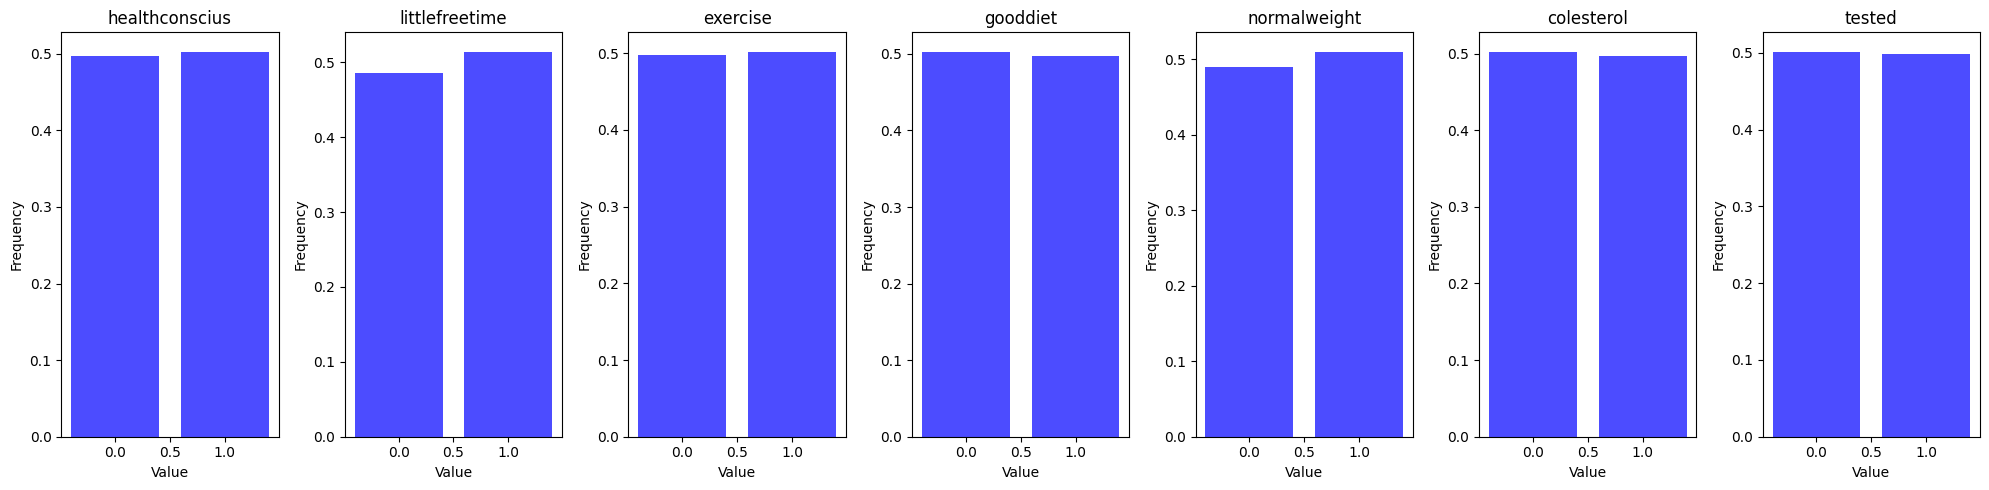

In [44]:
create_histogram(data, data_var_list)

In [45]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-4.0348)


### No sketching

In [46]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             1000
POPULATION_SIZE:         250



In [47]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [48]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-4.0348)
Found Program 
 healthconscius = gm([3, 1, 0], [3, 0, 0]); 
  littlefreetime = normalweight  - 2; 
  exercise = gooddiet  - 2 * 3; 
  gooddiet = 0; 
  normalweight = 9  * exercise  - colesterol; 
  colesterol = 0  * normalweight; 
  tested = gm([8, 1, 0], [1, 0, 0]) + gm([3, 1, 0], [8, 0, 0]); 
  exercise = 2 * 5  - gm([1, 1, 0], [5, 0, 0]);
 
 


In [49]:
samples = sample_gmm(output_dist, 5000)

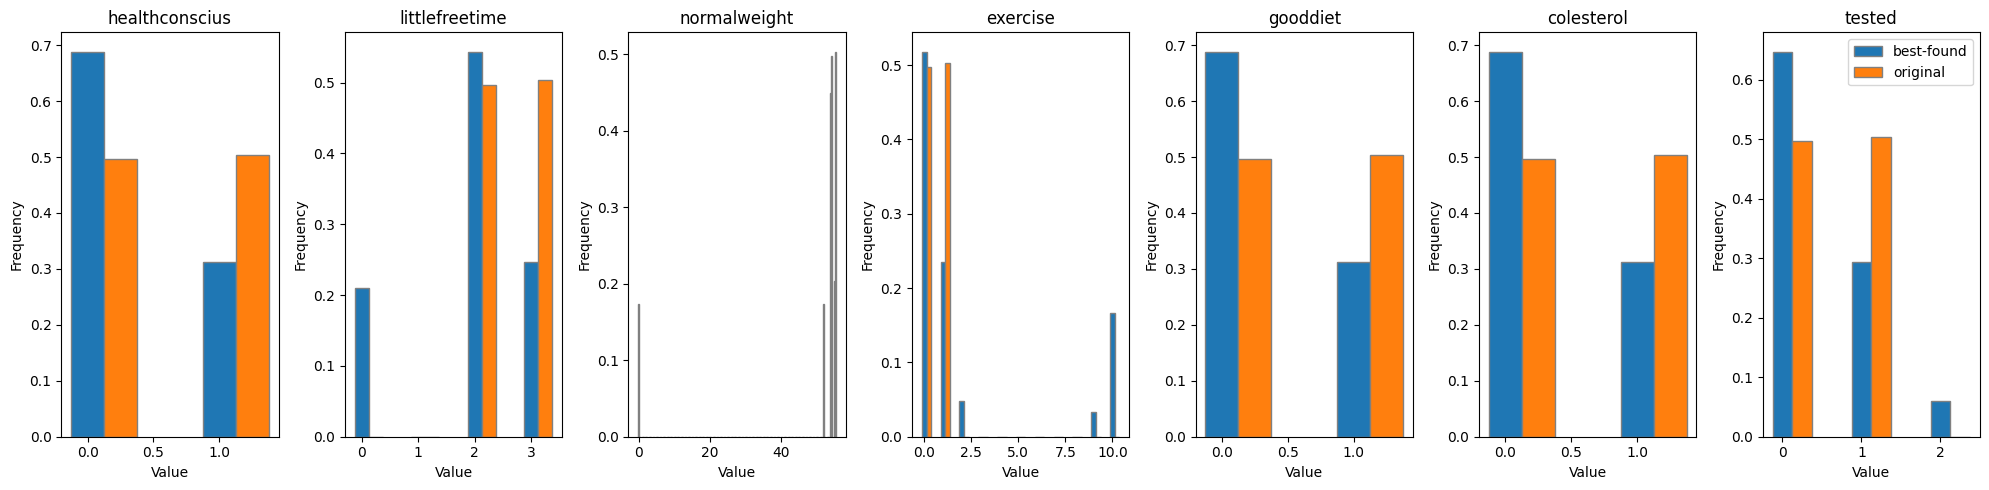

In [50]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [51]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             1000
POPULATION_SIZE:         250



In [52]:
sketch = ''' healthconscius = <right_assign> {::} littlefreetime = <right_assign> {::} 

if healthconscius == 1 { {: 
    if littlefreetime == 1 { {: 
        exercise = <right_assign> :}
    } else { {:
        exercise = <right_assign> :}
    } end if; :}
} else { {:
    if littlefreetime == 1 { {:
        exercise = <right_assign> :}
    } else { {:
        exercise = <right_assign> :}
    } end if;
:} } end if; {::}

if healthconscius == 1 { {:
    gooddiet = <right_assign> :}
} else { {:
    gooddiet = <right_assign> :}
} end if; {::}

if gooddiet == 1 { {:
    if exercise == 1 { {:
        normalweight = <right_assign> :}
    } else { {:
        normalweight = <right_assign> :}
    } end if; :}
} else { {:
    if exercise == 1 { {:
        normalweight = <right_assign> :}
    } else { {:
        normalweight = <right_assign> :}
    } end if; :}
} end if; {::}

if gooddiet == 1 { {:
    colesterol = <right_assign> :}
} else { {:
    colesterol = <right_assign> :}
} end if; {::}

if colesterol == 1 { {:
    tested = <right_assign> :}
} else { {:
    tested = <right_assign> :}
} end if;
'''

sketch = sketch.replace('\n', '')
print(sketch)

 healthconscius = <right_assign> {::} littlefreetime = <right_assign> {::} if healthconscius == 1 { {:     if littlefreetime == 1 { {:         exercise = <right_assign> :}    } else { {:        exercise = <right_assign> :}    } end if; :}} else { {:    if littlefreetime == 1 { {:        exercise = <right_assign> :}    } else { {:        exercise = <right_assign> :}    } end if;:} } end if; {::}if healthconscius == 1 { {:    gooddiet = <right_assign> :}} else { {:    gooddiet = <right_assign> :}} end if; {::}if gooddiet == 1 { {:    if exercise == 1 { {:        normalweight = <right_assign> :}    } else { {:        normalweight = <right_assign> :}    } end if; :}} else { {:    if exercise == 1 { {:        normalweight = <right_assign> :}    } else { {:        normalweight = <right_assign> :}    } end if; :}} end if; {::}if gooddiet == 1 { {:    colesterol = <right_assign> :}} else { {:    colesterol = <right_assign> :}} end if; {::}if colesterol == 1 { {:    tested = <right_assign> :}} 

In [53]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
try:
    output_dist = start_SOGA(cfg)
except IndexError:
    print('IndexError: found invalid program')

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

IndexError: found invalid program
tensor(-inf)


In [54]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-4.0348)
Found Program 
 healthconscius = littlefreetime  - normalweight; 
  littlefreetime = exercise + healthconscius; 
  if healthconscius == 1 { 
        if littlefreetime == 1 { 
              exercise = 5  * gm([5, 1, 0], [8, 0, 0]) + gooddiet; 
       } else { 
             exercise = colesterol; 
       } end if; 
 } else { 
       if littlefreetime == 1 { 
             exercise = 2 * 0; 
       } else { 
             exercise = 1  * gm([9, 1, 0], [8, 0, 0]); 
       } end if;
  } end if; 
 if healthconscius == 1 { 
       gooddiet = colesterol  - 1; 
 } else { 
       gooddiet = 6 * 8; 
 } end if; 
 if gooddiet == 1 { 
       if exercise == 1 { 
             normalweight = 3  * gooddiet + 6  * tested; 
       } else { 
             normalweight = 8  * gm([6, 1, 0], [5, 0, 0])  - 7; 
       } end if; 
 } else { 
       if exercise == 1 { 
             normalweight = 6; 
       } else { 
             norma

In [55]:
samples = sample_gmm(output_dist, 10000)

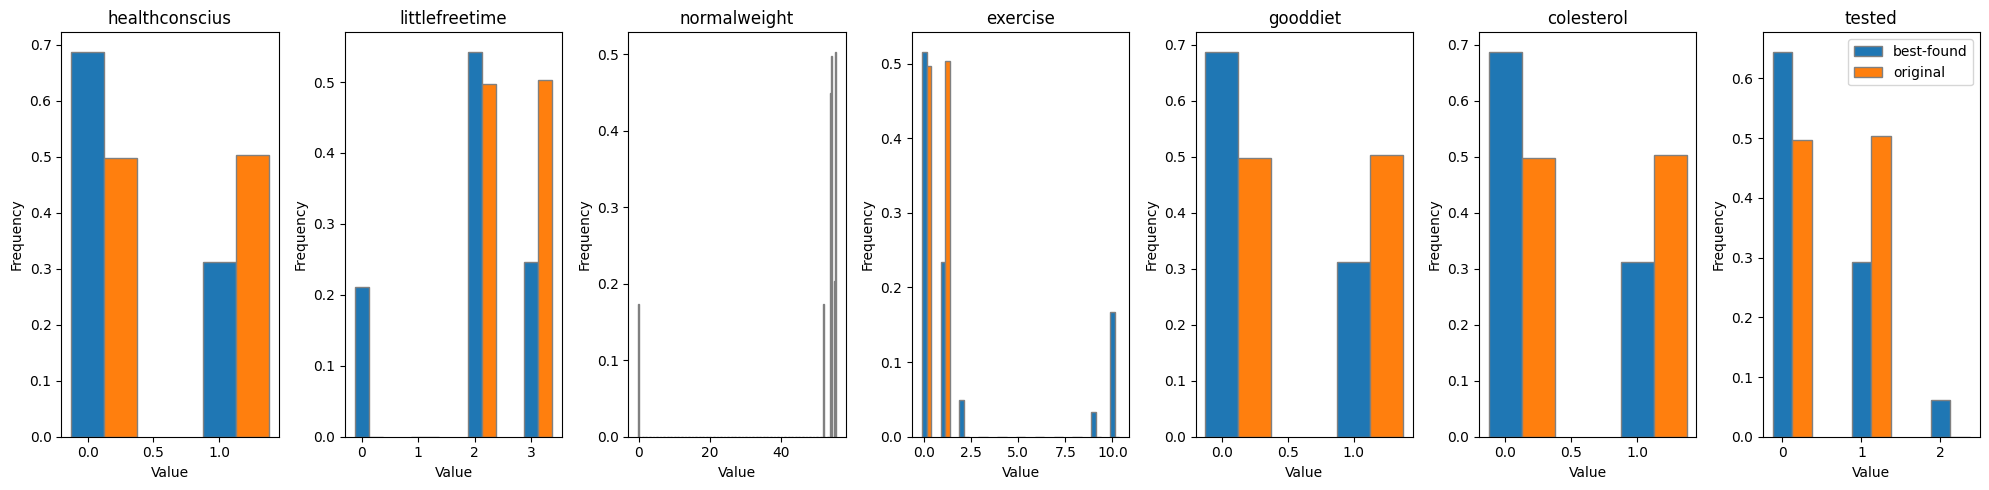

In [56]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Eyecolor

In [57]:
model_name = 'eyecolor'

### Data from the original data generating process

In [58]:
"""
def generate_eyecolor_dataset(data_size):
    data = []
    for _ in range(data_size):
        eye_color = np.random.choice([0, 1, 2, 3], [0.82, 0.08, 0.08, 0.02])
        if eye_color == 0:
            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.8, 0.05, 0.04, 0.01, 0.1])
        elif eye_color == 1:
            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.7, 0.15, 0.04, 0.01, 0.1])
        elif eye_color == 2:
            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.4, 0.3, 0.18, 0.03, 0.1])
        else:
            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.4, 0.29, 0.18, 0.03, 0.1])
        hair_length = np.random.choice([0, 1, 2], [0.6, 0.15, 0.25])
        data.append([eye_color, hair_color, hair_length])
"""

'\ndef generate_eyecolor_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        eye_color = np.random.choice([0, 1, 2, 3], [0.82, 0.08, 0.08, 0.02])\n        if eye_color == 0:\n            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.8, 0.05, 0.04, 0.01, 0.1])\n        elif eye_color == 1:\n            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.7, 0.15, 0.04, 0.01, 0.1])\n        elif eye_color == 2:\n            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.4, 0.3, 0.18, 0.03, 0.1])\n        else:\n            hair_color = np.random.choice([0, 1, 2, 3, 4], [0.4, 0.29, 0.18, 0.03, 0.1])\n        hair_length = np.random.choice([0, 1, 2], [0.6, 0.15, 0.25])\n        data.append([eye_color, hair_color, hair_length])\n'

In [59]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)

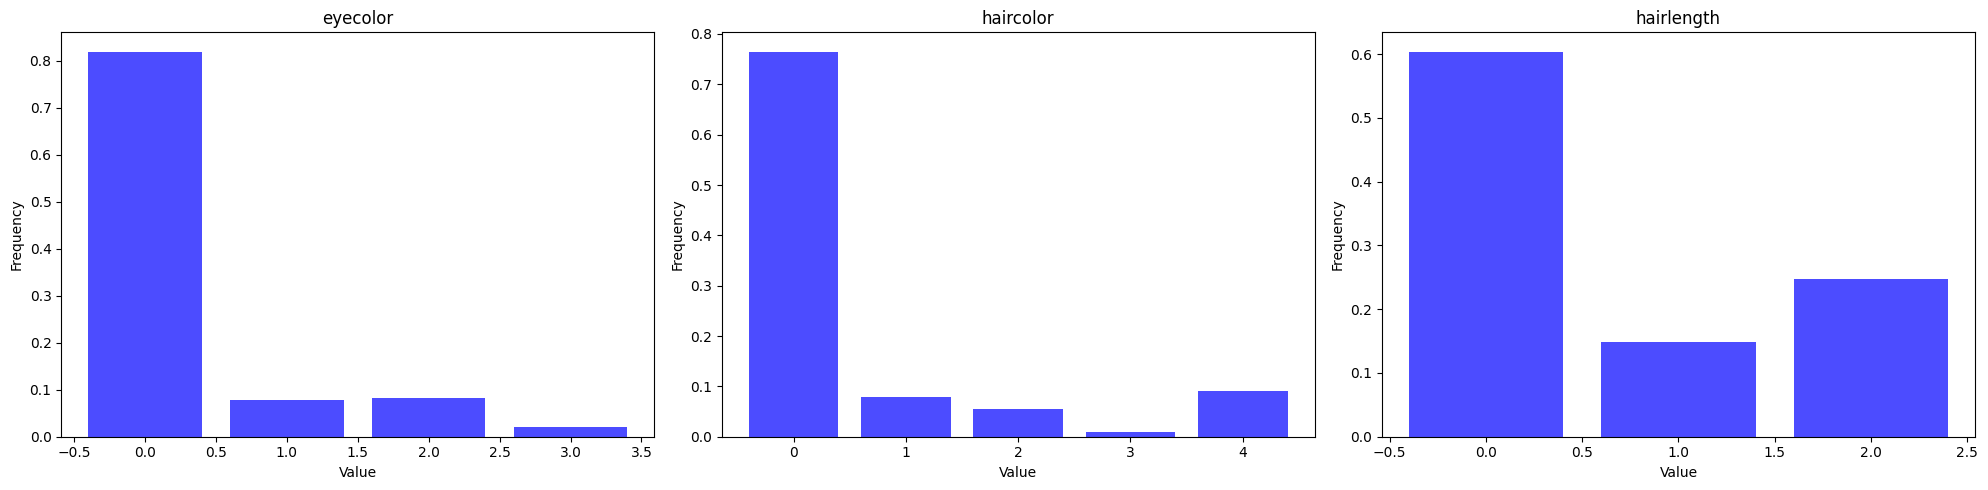

In [60]:
create_histogram(data, data_var_list)

In [61]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-2.3810)


### No sketching

In [69]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             500
POPULATION_SIZE:         150



In [74]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [75]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-2.3810)
Found Program 
 eyecolor = gm([9, 7, 0])  - 8  * gm([8, 5, 0]); 
  haircolor = gm([3.8, 1.7, 0])  - 1  * gm([5, 2, 0]); 
  hairlength = gm([4, 7, 0])  - 7 * 8; 
  eyecolor = 1  * hairlength + hairlength;
 
 


In [76]:
samples = sample_gmm(output_dist, 5000)

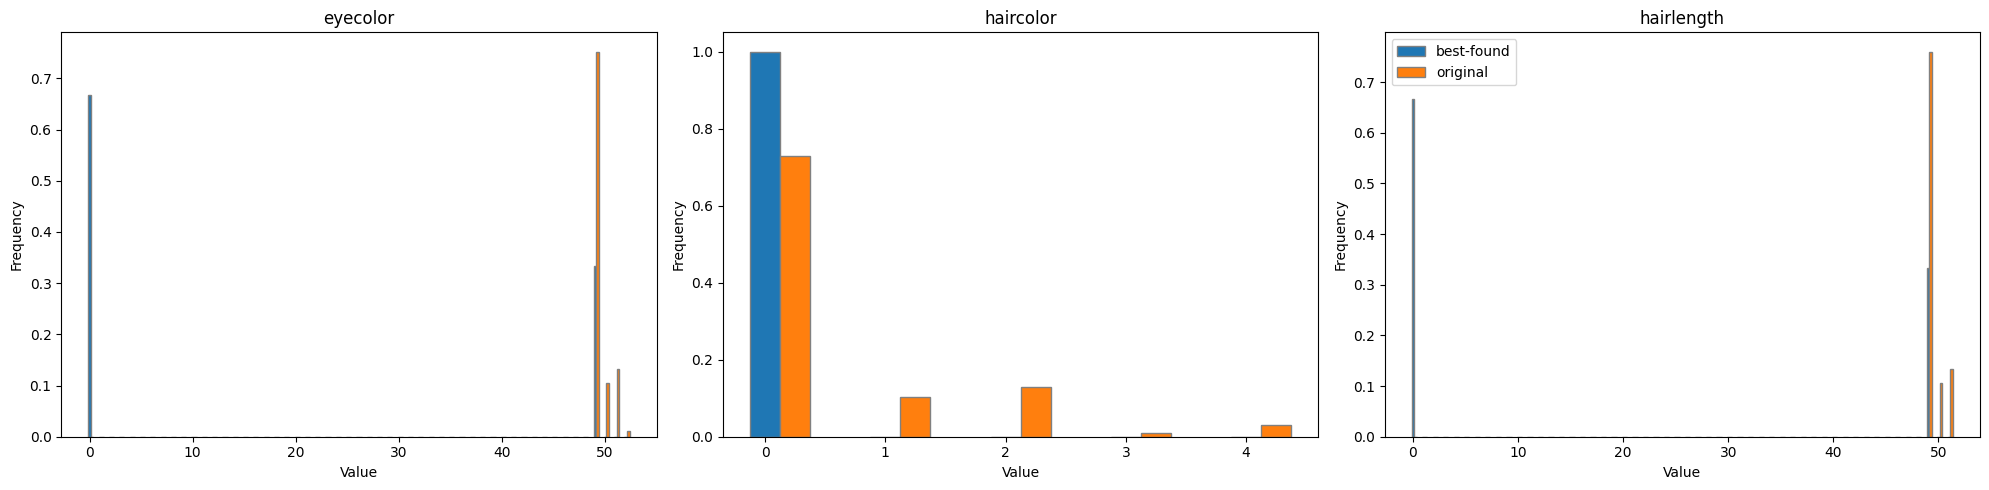

In [77]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [78]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/parameters.txt", 'r')
info = ''
for line in file.readlines():
    if 'GENERATIONS' in line or 'POPULATION_SIZE' in line:
        info += line
file.close()

print(info)

GENERATIONS:             500
POPULATION_SIZE:         150



In [79]:
sketch = ''' eyecolor = <right_assign> {::}

if eyecolor == 0 { {:
    haircolor = <right_assign> :}
} else { {:
    if eyecolor == 1 { {:
        haircolor = <right_assign> :}
    } else { {: 
        if eyecolor == 2 { {:
                haircolor = <right_assign> :}
        } else { {:
                haircolor = <right_assign> :}
        } end if; :}
    } end if; :}
} end if; {::}

hairlength = <right_assign>
'''

sketch = sketch.replace('\n', '')
print(sketch)

 eyecolor = <right_assign> {::}if eyecolor == 0 { {:    haircolor = <right_assign> :}} else { {:    if eyecolor == 1 { {:        haircolor = <right_assign> :}    } else { {:         if eyecolor == 2 { {:                haircolor = <right_assign> :}        } else { {:                haircolor = <right_assign> :}        } end if; :}    } end if; :}} end if; {::}hairlength = <right_assign>


In [81]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

IndexError: list index out of range

In [82]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-2.3810)
Found Program 
 eyecolor = hairlength  - 8 * 0; 
 if eyecolor == 0 { 
       haircolor = hairlength  - haircolor; 
 } else { 
       if eyecolor == 1 { 
             haircolor = haircolor; 
       } else { 
              if eyecolor == 2 { 
                       haircolor = haircolor + 0  * eyecolor; 
             } else { 
                       haircolor = eyecolor; 
             } end if; 
       } end if; 
 } end if; 
 hairlength = 8 * 7 + 1  * eyecolor;
 
 


In [83]:
samples = sample_gmm(output_dist, 10000)

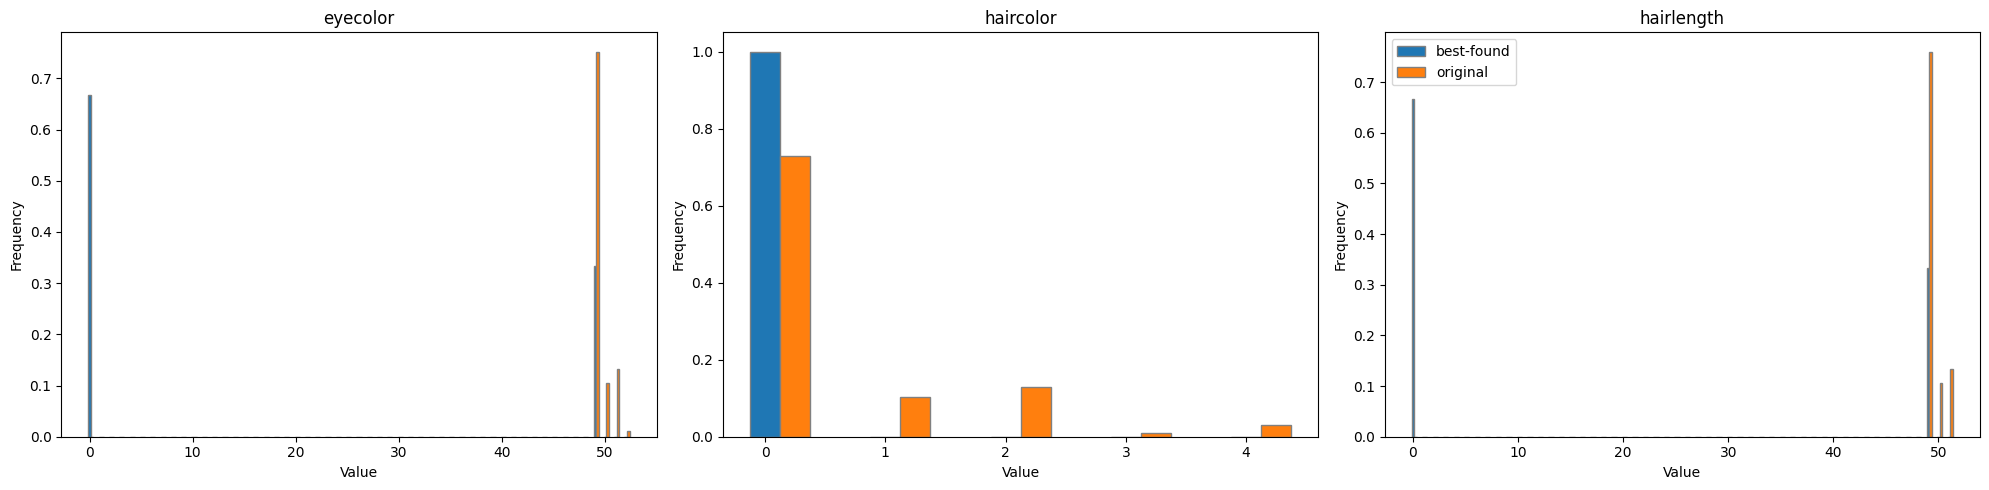

In [84]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Grass

In [54]:
model_name = 'grass'

### Data from the original data generating process

In [55]:
"""
def generate_grass_dataset(data_size):
    data = []
    for _ in range(data_size):
        rain = np.random.gaussian(4, 2)
        if rain < 1:
            sprinkler = 1
        else:
            sprinkler = 0
        if rain > 2:
            grasswet = 1
        else:
            if sprinkler:
                grasswet = 1
            else:
                grasswet = 0
    data.append([rain, sprinkler, grasswet])
"""

'\ndef generate_grass_dataset(data_size):\n    data = []\n    for _ in range(data_size):\n        rain = np.random.gaussian(4, 2)\n        if rain < 1:\n            sprinkler = 1\n        else:\n            sprinkler = 0\n        if rain > 2:\n            grasswet = 1\n        else:\n            if sprinkler:\n                grasswet = 1\n            else:\n                grasswet = 0\n    data.append([rain, sprinkler, grasswet])\n'

In [56]:
data = dgp.generate_dataset(model_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(model_name)

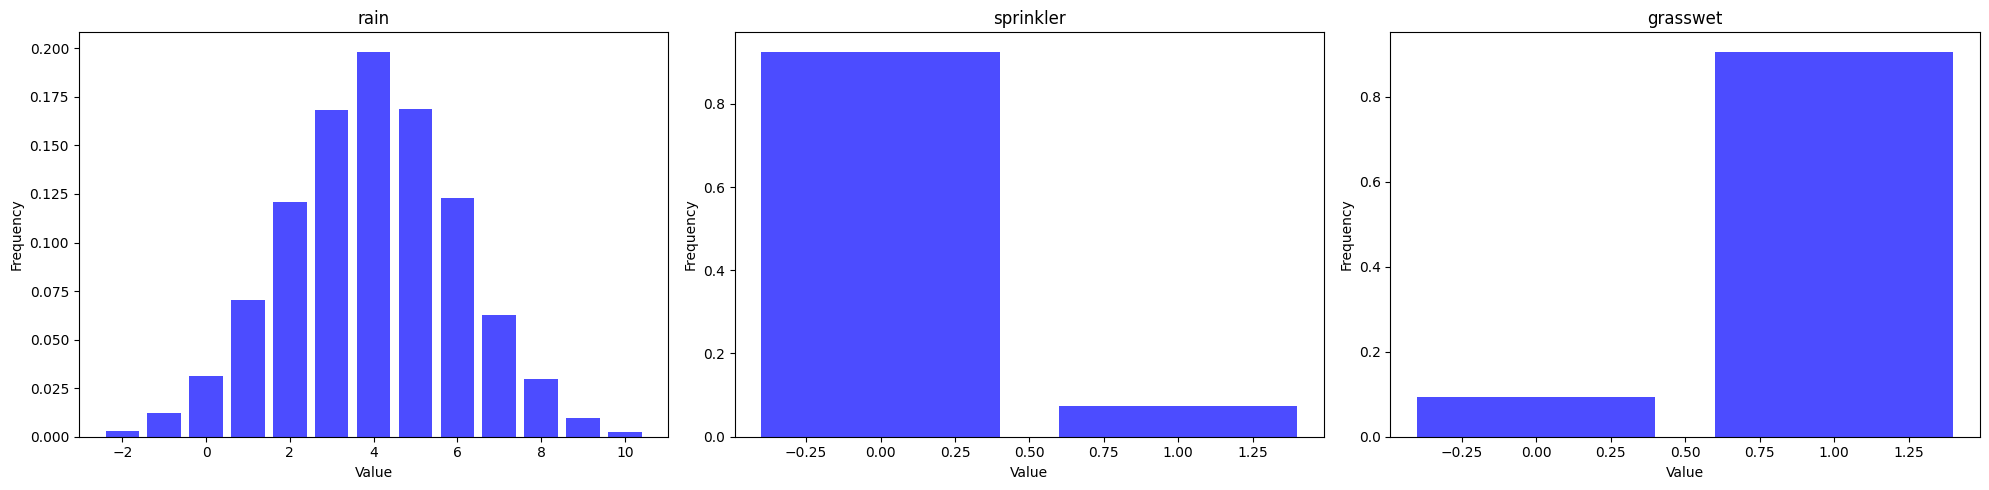

In [57]:
create_histogram(data, data_var_list)

In [59]:
file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
file.close()

soga_bl = preprocess_program(text_baseline)
compiledText=compile2SOGA_text(soga_bl)
cfg = produce_cfg_text(compiledText)
output_dist_baseline = start_SOGA(cfg)

fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)
print(fitness_baseline)

tensor(-2.3020)


### No sketching

In [ ]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-inf)


In [ ]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-inf)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = gm([11, 1, 0], [22, 0, 0]) + gm([1, 1, 0], [28, 0, 0]); 
  v = v + gm([25, 1, 0], [10, 0, 0]); 
  w = gm([14, 1, 0], [30, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([8, 1, 0], [21, 0, 0]); 
    } else { 
      x = 1  * w + gm([2, 1, 0], [11, 0, 0]); 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([3, 1, 0], [1, 0, 0]); 
    } else { 
      x = x + v; 
    }end if; 
  }end if;
 
 


In [ ]:
samples = sample_gmm(output_dist, 5000)

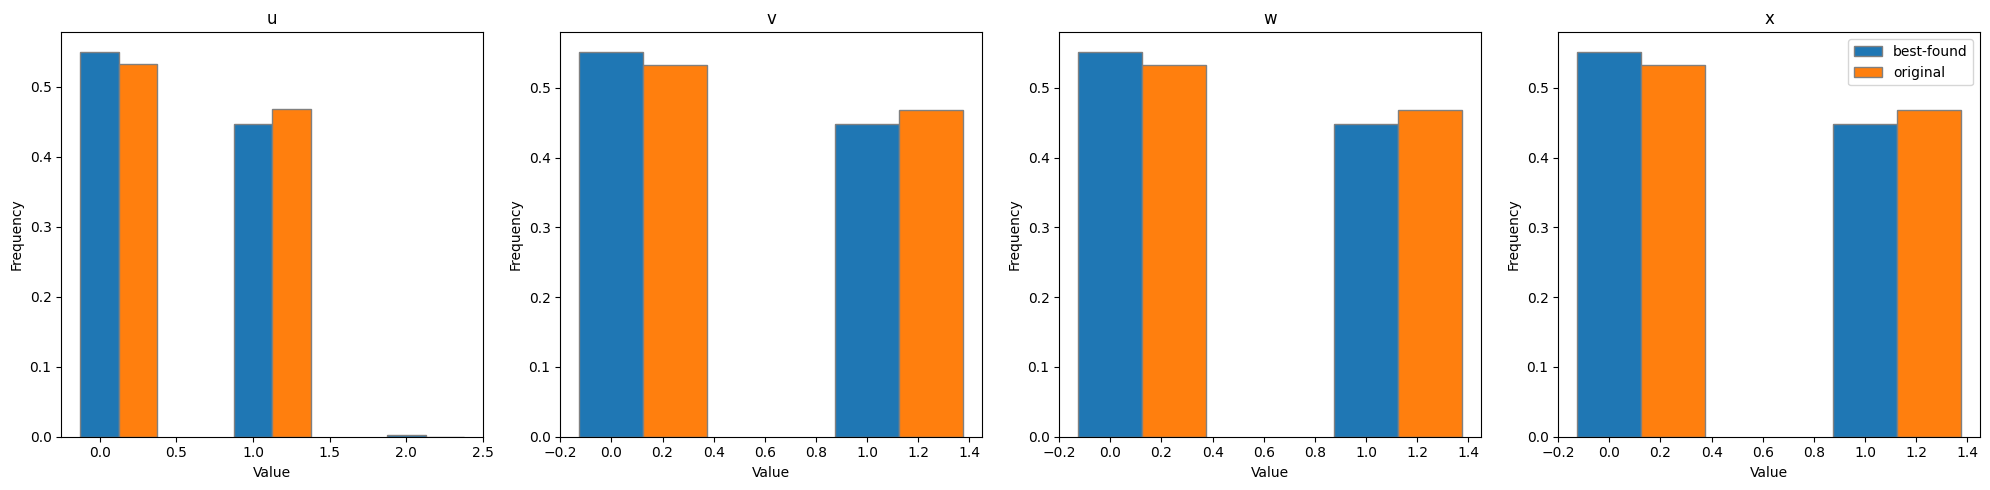

In [ ]:
# data from best found
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

### Sketching - no benefit

In [60]:
sketch = ''' rain = <right_assign> {::}

if rain <loperator> <num>  { {:
    sprinkler = <right_assign> :}
} else { {:
    sprinkler = <right_assign> :}
} end if; {::}

if rain <loperator> <num> { {:
    grasswet = <right_assign> :}
} else { {:
    if sprinkler == 1 { {:
        grasswet = <right_assign> :}
    } else { {:
        grasswet = <right_assign> :}
    } end if; :}
}end if; {::}
'''

sketch = sketch.replace('\n', '')
print(sketch)

 rain = <right_assign> {::}if rain <loperator> <num>  { {:    sprinkler = <right_assign> :}} else { {:    sprinkler = <right_assign> :}} end if; {::}if rain <loperator> <num> { {:    grasswet = <right_assign> :}} else { {:    if sprinkler == 1 { {:        grasswet = <right_assign> :}    } else { {:        grasswet = <right_assign> :}    } end if; :}}end if; {::}


In [ ]:
file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben1/best.txt", 'r')
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '
file.close()

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

fitness_bf = compute_likelihood(output_dist, data_var_list, data)
print(fitness_bf)

tensor(-1.8900)


In [ ]:
print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_baseline)

print('Found Program \n', text_bf) 

Fitness of best found program:  tensor(-1.8900)
Fitness of baseline:  tensor(-1.7547)
Found Program 
 u = 0  * gm([7, 1, 0], [29, 0, 0]) + gm([17, 1, 0], [29, 0, 0]); 
  v = gm([24, 1, 0], [5, 0, 0]); 
  w = gm([1, 1, 0], [24, 0, 0]); 
  if u == 1 { 
    if w == 1 { 
      x = gm([12, 1, 0], [7, 0, 0]); 
    } else { 
      x = gm([15, 1, 0], [13, 0, 0])  - x; 
    }end if; 
  } else { 
    if v == 1 { 
      x = gm([27, 1, 0], [6, 0, 0]); 
    } else { 
      x = gm([13, 1, 0], [22, 0, 0]); 
    }end if; 
  }end if;
 
 


In [ ]:
samples = sample_gmm(output_dist, 10000)

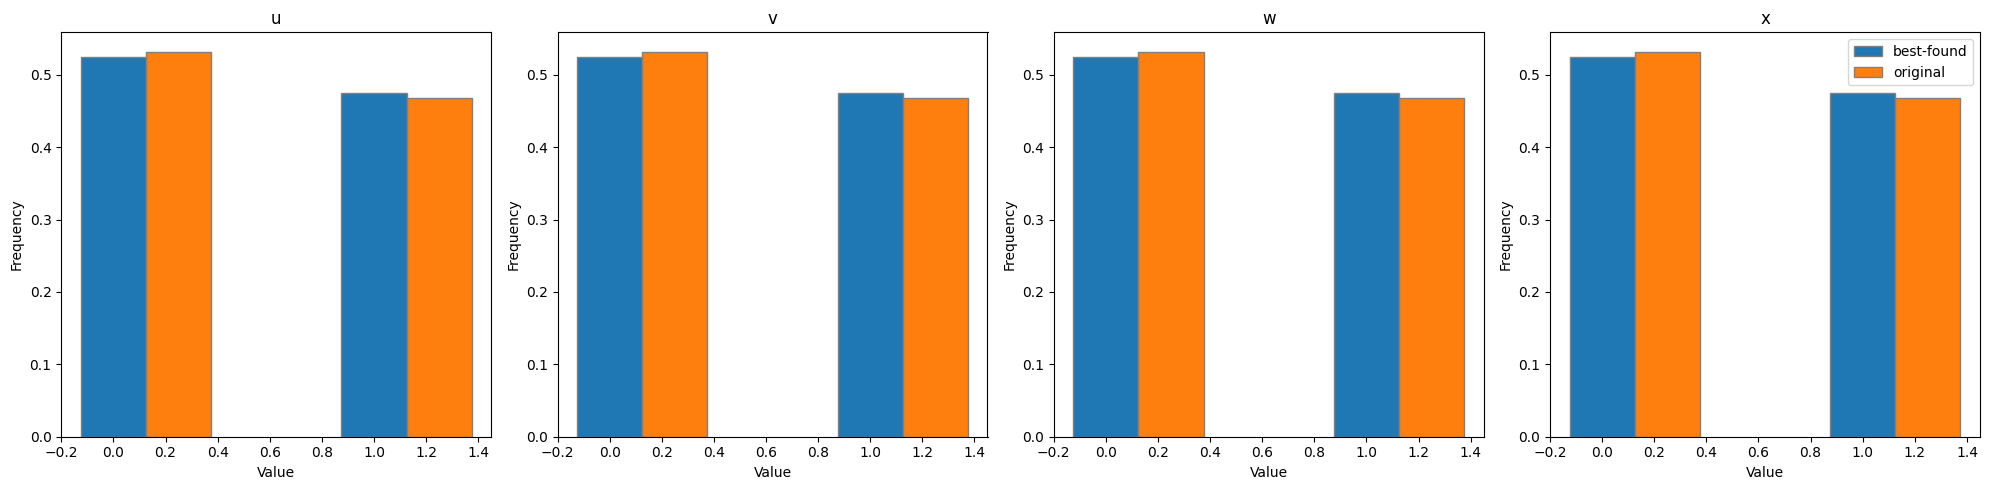

In [ ]:
# histogram best found program
create_histograms([samples, data], ['best-found', 'original'], output_dist.var_list)

# Results

In [53]:
models = ['burglary', 'csi', 'healthiness']

for model_name in models:
    
    # best no sketch
    file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/no-sketch/best.txt", 'r')
    nosketch_fitness = ''
    flag = False
    for line in file.readlines():
        if 'Fitness:' in line:
            flag = True
            continue
        if flag:
            nosketch_fitness += line
            break
    file.close()

    # best sketch
    file = open("C:/Users/birik/github/PonyGE2/results/"+model_name+"/sketch-noben/best.txt", 'r')
    sketch_fitness = ''
    flag = False
    for line in file.readlines():
        if 'Fitness:' in line:
            flag = True
            continue
        if flag:
            sketch_fitness += line
            break
    file.close()

    # baseline
    file = open('C:/Users/birik/github/PonyGE2/baselines/'+model_name+'.soga', 'r')
    text_baseline = ''
    for line in file.readlines():
        text_baseline += line + ' '
    file.close()
    soga_bl = preprocess_program(text_baseline)
    compiledText=compile2SOGA_text(soga_bl)
    cfg = produce_cfg_text(compiledText)
    output_dist_baseline = start_SOGA(cfg)
    data = dgp.generate_dataset(model_name, 500)
    data_var_list, dependencies, weights = dgp.get_vars(model_name)
    fitness_baseline = compute_likelihood(output_dist_baseline, data_var_list, data)

    print(model_name)
    print(' no sketching:', nosketch_fitness)
    print(' sketching:', sketch_fitness)
    print(' baseline fitness:', fitness_baseline)

burglary
 no sketching: 0.0
 sketching: -0.10008335329383025
 baseline fitness: tensor(-0.2323)
csi
 no sketching: -1.9059570749106631
 sketching: -1.4971546472669968
 baseline fitness: tensor(-1.7211)
healthiness
 no sketching: -inf
 sketching: -inf
 baseline fitness: tensor(-4.0466)
